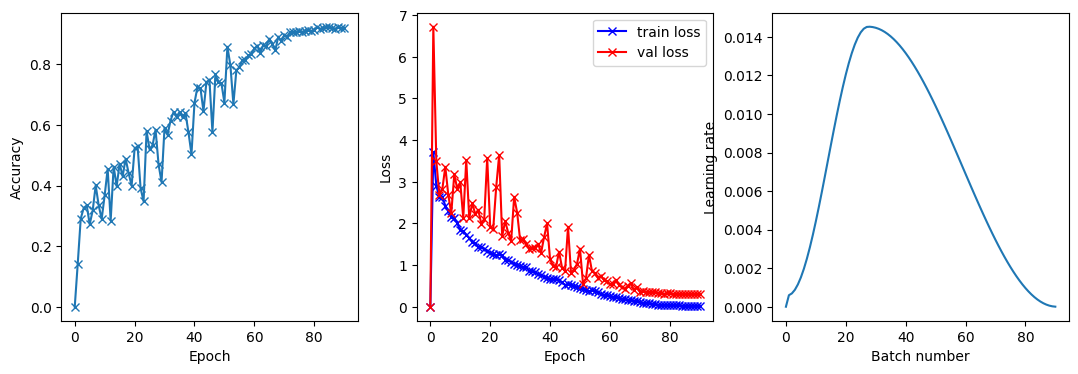

In [1]:
import pandas as pd
import processing

root = './output/resnet_20230219_234307.csv'
history = pd.read_csv(root)
processing.plot_history(history)

Load model

In [17]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from functions import show_batch, ToDeviceLoader
from datasets.openflowers import Flowers, test_transform
from models.ResNet import ResNet, ResBlock, ResBottleneckBlock
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

test_data = Flowers(
    split = 'test',
    image_root = './data/flowers-102/jpg/',
    transform = test_transform
)

test_dl = DataLoader(test_data, batch_size=64,shuffle=False)
test_dl = ToDeviceLoader(test_dl, device)

model = ResNet(3, ResBottleneckBlock, [3,4,6,3], useBottleneck=True, outputs=test_data.num_classes).to(device)
model.load_state_dict(torch.load('./dict/'+'resnet50-90e'+'.pt'))

Using cuda device


<All keys matched successfully>

In-out of set binary classification

In [28]:
model.eval()

tau = 0.9
predictions = []
labels = []

for X,y in test_dl:
    with torch.no_grad():
        pred = model(X)
        
        pred = F.softmax(pred, dim=1)
        max_softmax = torch.max(pred, dim=1)[0]
        binary_preds = [1 if i > tau else 0 for i in max_softmax]
        y = y.cpu().detach().numpy().tolist()
        predictions.extend(binary_preds)
        labels.extend(y)

In [29]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,


roc_auc_score:  0.645605423844813


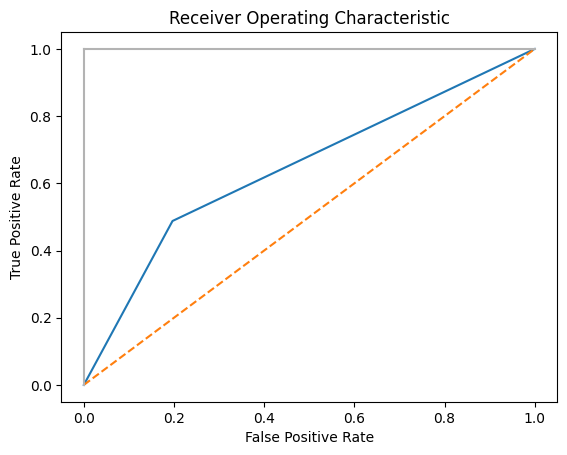

In [30]:
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, threshold = roc_curve(labels, predictions)

print('roc_auc_score: ', roc_auc_score(labels, predictions))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()